# Lesson 1 - Creating a 1 bit Full Adder

A 1 bit full adder is a circuit that adds two bits (a) and (b) and an additional carry input (ci). The result is an output (r) and a carry bit (co).

1 bit full adders can be chained to create adders of arbitrary number of bits.

The logic circuit can be described by its truth table

| a | b | ci | r  | co  |
|--- |--- |--- |--- |---|
| 0  | 0  | 0  |  0 | 0  |
| 0  | 0  | 1  |  1 | 0  |
| 0  | 1  | 0  |  1 | 0  |
| 0  | 1  | 1  |  0 | 1  |
| 1  | 0  | 0  |  1 | 0  |
| 1  | 0  | 1  |  0 | 1  |
| 1  | 1  | 0  |  0 | 1  |
| 1  | 1  | 1  |  1 | 1  |

The following diagram (from [https://www.fpga4student.com/2018/07/verilog-code-for-ripple-carry-adder.html]) depicts a possible implementation of the previous truth table.

![Full adder diagram](full_adder_diagram.jpg "Full adder diagram").

In the same webpage you can find an implementation in Verilog.

    // fpga4student.com: FPGA projects, Verilog projects, VHDL projects
    // Verilog project: Verilog code for 4-bit ripple-carry adder
    // Verilog code for 1-bit full adder
    module fulladder(X, Y, Ci, S, Co);
      input X, Y, Ci;
      output S, Co;
      wire w1,w2,w3;
      //Structural code for one bit full adder
      xor G1(w1, X, Y);
      xor G2(S, w1, Ci);
      and G3(w2, w1, Ci);
      and G4(w3, X, Y);
      or G5(Co, w2, w3);
    endmodule
    
Most FPGA design tools will require you to compile the design to a certain degree (requiring some minutes) to show a diagram that resembles something similar to the previous image.   

### Now, we do the same structural design in py4hw

In [8]:
import sys
import platform
if (platform.uname().node == 'TPY14'):
    print('Dev machine')
    sys.path.append('..\\..\\..\\py4hw')

Dev machine


In [9]:
import py4hw

In [10]:
class FullAdder(py4hw.Logic):
    
    def __init__(self, parent, name, x, y, ci, s, co):
        super().__init__(parent, name)
        
        x = self.addIn('x', x)
        y = self.addIn('y', y)
        ci = self.addIn('ci', ci)
        s = self.addOut('s', s)
        co = self.addOut('co', co)

        w1 = self.wire('w1',1)
        w2 = self.wire('w2',1)
        w3 = self.wire('w3',1)
        
        py4hw.Xor2(self, 'g1', x, y, w1)
        py4hw.Xor2(self, 'g2', w1, ci, s)
        py4hw.And2(self, 'g3', w1, ci, w2)
        py4hw.And2(self, 'g4', x, y, w3)
        py4hw.Or2(self, 'g5', w2, w3, co)
        

Note some differences

1- We define a class (instead of a module) which inherits from py4hw.Logic. All circuits must inherit from Logic in py4hw.

2- The constructor of the class provides a parent and a name. All circuits must provide a parent and a name that must be passed to the constructor of the base class. The parent object is used to maintain the hierarchy. So all circuits have a link to their parent (self.parent) and all circuits have a dictionary with their children (self.children) which is keyed by the provided name. Children names must be unique in the parent scope.

3- Constructor parameters do no define (at all) the circuit interface. The circuit interface is defined during runtime by calling addIn and addOut methods.

4- The width of the ports are not specified. In py4hw port widths are never specified. On contrast, wire widths are always specified. Port widths are determined automatically during runtime depending on the wires connected to the ports.

5- And2, Xor2, Or2 are primitive circuits provided by the framework.

### Testing the circuit

You can test the circuit by instantiating it.

We will use the object HWSystem, which is the top level entity on all py4hw designs.

In [11]:
sys = py4hw.HWSystem()

x = sys.wire('x')
y = sys.wire('y')
ci = sys.wire('ci')
s = sys.wire('s')
co = sys.wire('co')
fa = FullAdder(sys, 'fa', x, y, ci, s, co)

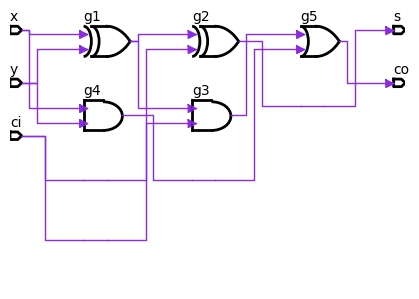

In [12]:
sch = py4hw.Schematic(fa)
sch.draw()


### What about Simulating it ?
In Verilog you would need to use a Gate Level Simulator. Standard practice is to use a commercial tool like QuestaSim, or opensource alternatives such as Icarus or Verilator. In any case, people usually have to change either tools or language to create the testbenches.

This is how it is done in py4hw...

In [13]:
sys = py4hw.HWSystem()

x = sys.wire('x')
y = sys.wire('y')
ci = sys.wire('ci')
s = sys.wire('s')
co = sys.wire('co')

py4hw.Sequence(sys, 'ci', [0,1], ci)
py4hw.Sequence(sys, 'y', [0,0,1,1], y)
py4hw.Sequence(sys, 'x', [0,0,0,0,1,1,1,1], x)

fa = FullAdder(sys, 'fa', x, y, ci, s, co)

wf = py4hw.Waveform(sys, 'wf', [x, y, ci, s, co])
sys.getSimulator().clk(20)
## Draw with matplotlib
#wf.draw()
#import matplotlib.pyplot as plt
#plt.show()

# Draw with nbwavedrom 
wf.draw_wavedrom(ShortName=True)


TypeError: draw_wavedrom() got an unexpected keyword argument 'ShortName'

### How to synthesize this?
Right, this is good, but ... you probably want to sinthesize this design. Ok, here we go

In [9]:
rtlgen = py4hw.VerilogGenerator(fa)

print(rtlgen.getVerilog(noInstanceNumber=True))

// This file was automatically created by py4hw RTL generator
module FullAdder (
	input  x,
	input  y,
	input  ci,
	output  s,
	output  co);
wire w_w1;
wire w_w2;
wire w_w3;

assign w_w1 = x ^ y;
assign s = w_w1 ^ ci;
assign w_w2 = w_w1 & ci;
assign w_w3 = x & y;
assign co = w_w2 | w_w3;
endmodule



Some comments:

1- As you can see, some primitives (and2, xor2, or2) are direcly inlined as behavioural verilog assign statements. More complex circuits would appear as verilog structural circuit instantiation.

2- Current Verilog generation uses a technique in independent RTL is generated for every circuit instance of the circuit. This requires to identify each instance (with a number). But tipically we do not want that number to appear in the top level entity of our circuit, so we pass the parameter noInstanceNumber=True to avoid it.
More advanced RTL generation techniques will be implemented in future py4hw releases. For more details, see the discussion in [Section 7.1](s07/Structures.ipynb) of the User Guide.